<a href="https://colab.research.google.com/github/ailinnesse/nn-zero-to-hero/blob/main/micrograd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [33]:
import math
import numpy as np
import math
import random
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
def f(x):
  return 3*x**2 - 4*x + 5

In [ ]:
f(3.0)


20.0

In [ ]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
ys

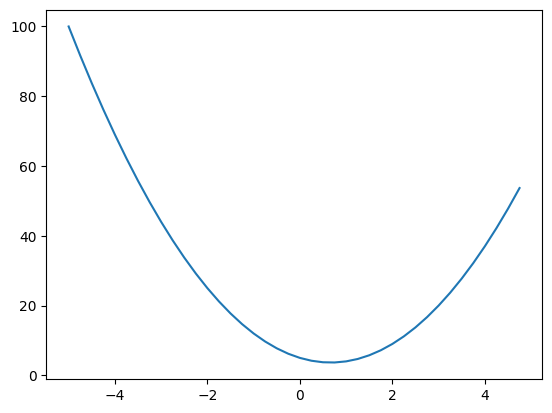

In [ ]:
plt.plot(xs, ys)

In [ ]:
h = 0.0000000001
x = 2/3
(f(x+h) - f(x))/h

0.0

In [ ]:
# les get more complex
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
print(d)

4.0


In [ ]:
h = 0.00001
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
d1 = a*b + c
c += h
d2 = a*b + c

In [ ]:
print('d1', d1)
print('d2', d2)
print('slope', (d2 - d1) / h)

d1 4.0
d2 4.00001
slope 0.9999999999621422


In [21]:
class Value:

  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"

  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')

    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward

    return out

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')

    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward

    return out


  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Value(self.data**other, (self,), f'**{other}')

    def _backward():
        self.grad += other * (self.data ** (other - 1)) * out.grad
    out._backward = _backward

    return out


  def __rmul__(self, other):
    return self * other

  def __truediv__(self, other):
    return self * other ** -1

  def __neg__(self): # -self
    return self * -1

  def __sub__(self, other): # self - other
    return self + (-other)


  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')

    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward

    return out

  def exp(self):
    x = self.data

    out = Value(math.exp(x), (self, ), 'exp')

    def _backward():
      self.grad += out.data * out.grad
    out._backward = _backward

    return out

  def backward(self):

    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)

    self.grad = 1.0
    for node in reversed(topo):
      node._backward()


a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'
L

Value(data=-8.0)

In [22]:
a = Value(2.0)
b = Value(3.0)
a - b

Value(data=-1.0)

In [ ]:
d._op

'+'

In [23]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot


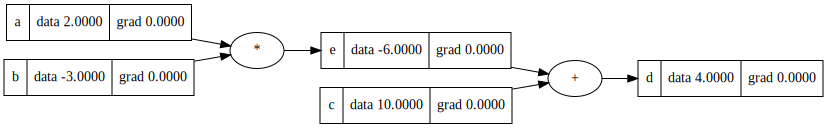

In [ ]:
draw_dot(d)

In [ ]:
def lol():

  h = 0.0001

  a = Value(2.0, label = 'a')
  b = Value(-3.0, label='b')
  c = Value(10.0, label = 'c')
  e = a*b; e.label = 'e'
  d = e + c; d.label = 'd'
  f = Value(-2.0, label = 'f')
  L = d*f; L.label = 'L'
  L1 = L.data


  a = Value(2.0, label = 'a')
  b = Value(-3.0, label='b')
  c = Value(10.0, label = 'c')
  e = a*b; e.label = 'e'
  d = e + c; d.label = 'd'
  f = Value(-2.0, label = 'f')
  L = d*f; L.label = 'L'
  L2 = L.data + h


  print((L2 - L1)/h)

lol()

0.9999999999976694


In [ ]:
L.grad = 1.0
f.grad = 4.0
d.grad = -2.0

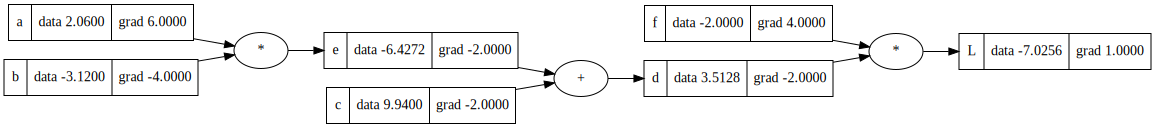

In [ ]:
draw_dot(L)

In [ ]:
c.grad = -2.0

In [ ]:
e.grad = -2.0
b.grad = -2.0 * 2.0
a.grad = (-2.0 * -3.0)

In [ ]:
a.data += 0.01 * a.grad

In [ ]:
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label = 'f')
L = d*f; L.label = 'L'

In [ ]:
L.data

-7.0256000000000025

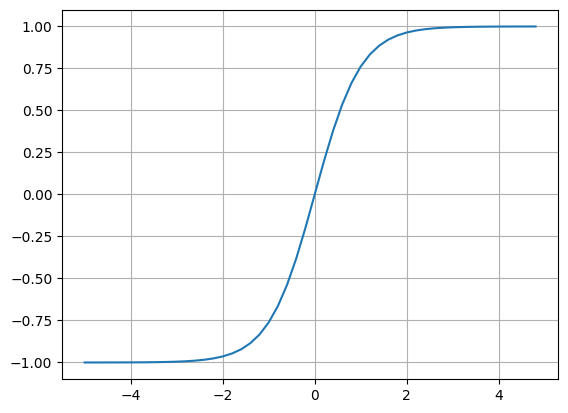

In [ ]:
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2))); plt.grid();

In [24]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

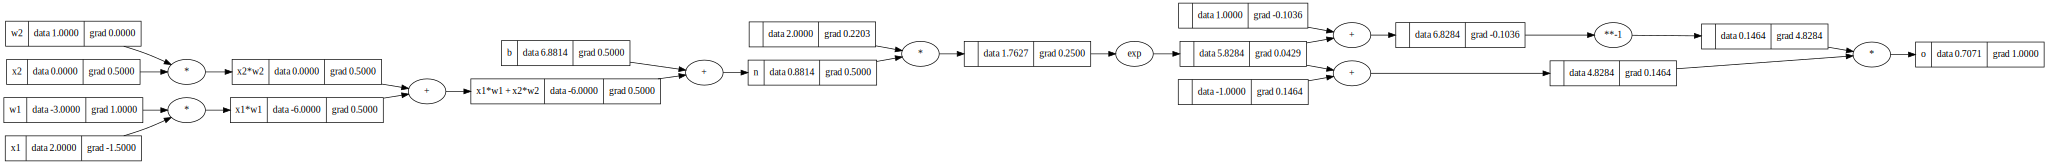

In [25]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
e = (2*n).exp()
o = (e - 1) / (e + 1)
# ----
o.label = 'o'
o.backward()
draw_dot(o)

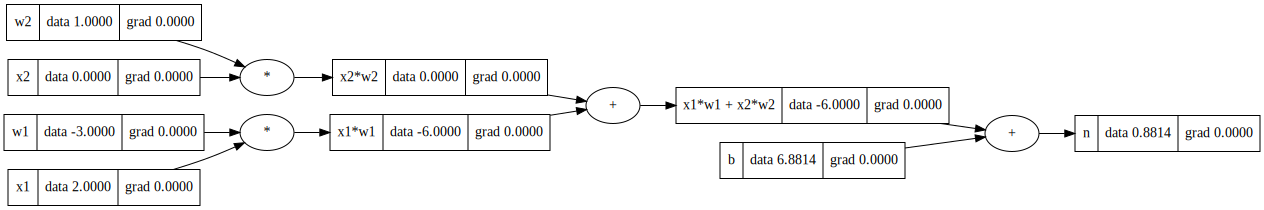

In [ ]:
draw_dot(n)

In [6]:
o.backward()

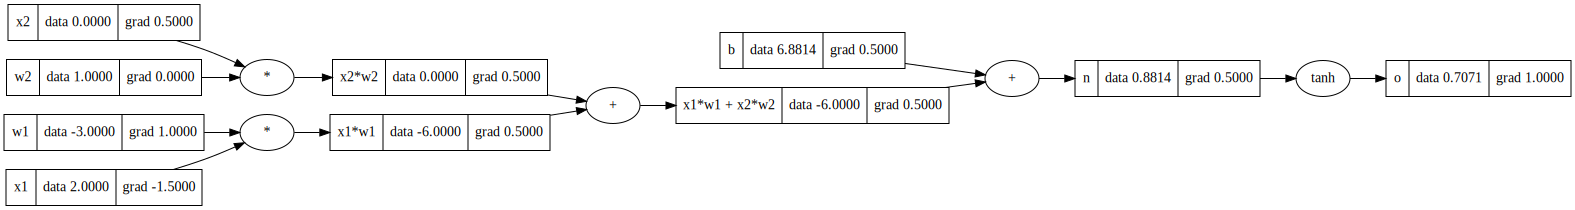

In [7]:
draw_dot(o)

In [ ]:
n.grad = 1 - o.data **2

In [ ]:
b.grad = n.grad

In [ ]:
x1w1x2w2.grad = 0.5
x1w1.grad = 0.5
x2w2.grad= 0.5

In [ ]:
x1.grad = w1.data * x1w1.grad
w1.grad = x1.data * x1w1.grad

x2.grad = w2.data * x2w2.grad
w2.grad = x2.data * x2w2.grad

In [ ]:
topo = []
visited = set()
def build_topo(v):
  if v not in visited:
    visited.add(v)
    for child in v._prev:
      build_topo(child)
    topo.append(v)
build_topo(o)
topo

[Value(data=0.0),
 Value(data=1.0),
 Value(data=0.0),
 Value(data=2.0),
 Value(data=-3.0),
 Value(data=-6.0),
 Value(data=-6.0),
 Value(data=6.881373587019543),
 Value(data=0.8813735870195432),
 Value(data=0.7071067811865476)]

In [ ]:
for node in reversed(topo):
  node._backward()

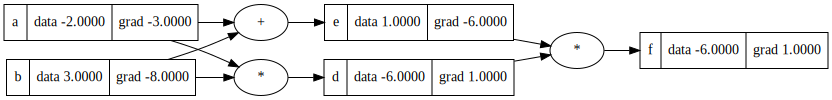

In [8]:
a = Value(-2.0, label='a')
b = Value(3.0, label='b')
d = a * b    ; d.label = 'd'
e = a + b    ; e.label = 'e'
f = d * e    ; f.label = 'f'

f.backward()

draw_dot(f)

In [26]:
import torch

In [27]:
x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [28]:
torch.Tensor([2.0]).double().dtype

torch.float64

In [29]:
o

tensor([0.7071], dtype=torch.float64, grad_fn=<TanhBackward0>)

In [31]:
o.item()

0.7071066904050358

In [73]:
class Neuron:

  def __init__(self, nin):
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1,1))

  def __call__(self, x):
    # w * x + b
    act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
    out = act.tanh()
    return out

  def parameters(self):
    return self.w + [self.b]

class Layer:

  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]

  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs

  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:

  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x

  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]

In [75]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=-0.18687582429534424)

In [76]:
n.parameters()

[Value(data=0.15412230454693532),
 Value(data=0.23681225665536987),
 Value(data=0.757642097088099),
 Value(data=-0.6838297835712479),
 Value(data=-0.49224872205032666),
 Value(data=-0.24610880574313598),
 Value(data=-0.3662774291656692),
 Value(data=-0.09591098838147483),
 Value(data=-0.09830218251308698),
 Value(data=-0.4206085524033183),
 Value(data=0.4843385114047629),
 Value(data=0.9068368610000404),
 Value(data=-0.8983474664651299),
 Value(data=0.4102856166805975),
 Value(data=0.06479909537030926),
 Value(data=-0.6509972188531792),
 Value(data=0.46369423456694436),
 Value(data=-0.36290004663848197),
 Value(data=-0.6786382760657848),
 Value(data=0.7432713625873428),
 Value(data=0.4248439960631105),
 Value(data=-0.17523042365971242),
 Value(data=-0.03130844669463673),
 Value(data=0.6206305019384326),
 Value(data=0.7037563074170476),
 Value(data=0.3665353022861544),
 Value(data=-0.6709944180118215),
 Value(data=0.7477614657831246),
 Value(data=-0.550266161113478),
 Value(data=-0.4769

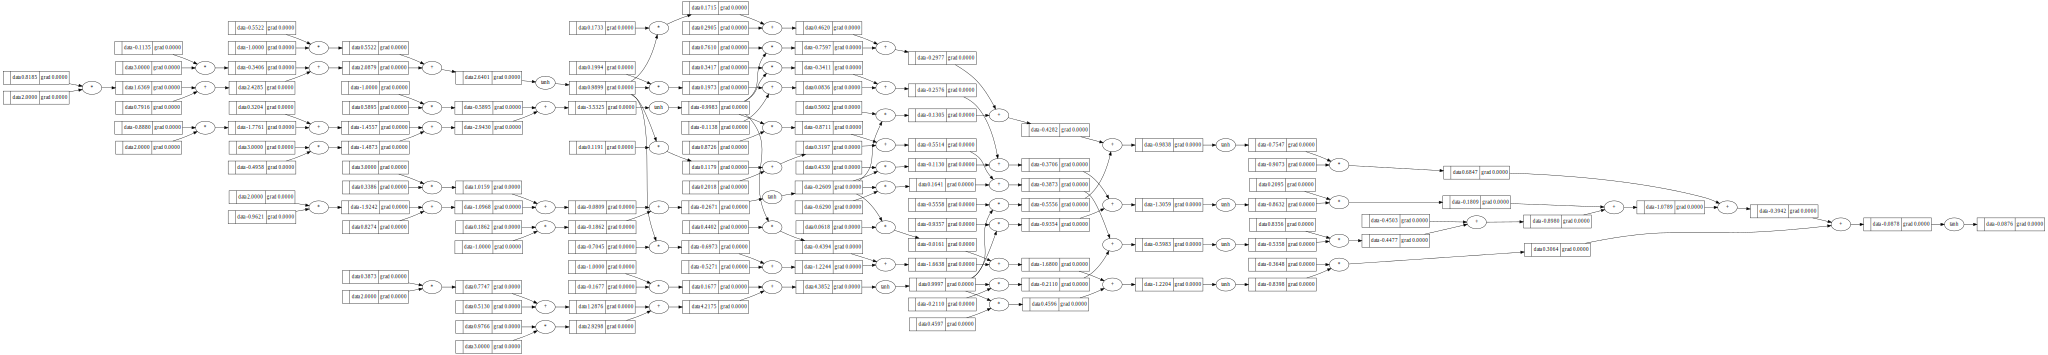

In [69]:
draw_dot(n(x))

In [77]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

In [78]:
ypred = [n(x) for x in xs]
ypred


[Value(data=-0.18687582429534424),
 Value(data=-0.2515130861695543),
 Value(data=-0.3318784431610874),
 Value(data=0.13217017278165266)]

In [81]:
n.layers[0].neurons[0].w[0].grad

0.0

In [82]:
n.layers[0].neurons[0].w[0].data

0.15412230454693532

In [92]:
for p in n.parameters():
  p.data += -0.01 * p.grad

In [101]:
loss = sum(
    ((yout - Value(ygt))**2 for ygt, yout in zip(ys, ypred)),
    start=Value(0.0)
)

In [102]:

loss

Value(data=3.1684219061948573)

In [147]:
for k in range(20):

  # forward pass
  ypred = [n(x) for x in xs]
  loss = sum(
    ((yout - Value(ygt))**2 for ygt, yout in zip(ys, ypred)),
    start=Value(0.0)
)

  # backward pass
  for p in n.parameters():
    p.grad = 0.0
  loss.backward()

  # update
  for p in n.parameters():
    p.data += -0.2 * p.grad

  print(k, loss.data)


0 0.0003705157863922757
1 0.0003697170782855881
2 0.00036892167743114777
3 0.0003681295636328556
4 0.0003673407168574045
5 0.00036655511723267416
6 0.0003657727450460873
7 0.00036499358074306386
8 0.000364217604925398
9 0.000363444798349759
10 0.00036267514192611704
11 0.00036190861671622863
12 0.000361145203932169
13 0.0003603848849348248
14 0.0003596276412324303
15 0.00035887345447913976
16 0.0003581223064735773
17 0.00035737417915744695
18 0.00035662905461410937
19 0.0003558869150672281


In [148]:
ypred = [n(x) for x in xs]
ypred


[Value(data=0.9919584409726219),
 Value(data=-0.994372532354421),
 Value(data=-0.9887044064988227),
 Value(data=0.9885447720824639)]